In [12]:
import dspy
import phoenix as px
import os
import json

In [13]:
px.launch_app()
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

WARNI [phoenix.session.session] Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


WARNI [opentelemetry.trace] Overriding of current TracerProvider is not allowed
WARNI [opentelemetry.instrumentation.instrumentor] Attempting to instrument while already instrumented


In [14]:
DATA_DIR = './data/derived_datasets/'
PROP_CLUSTERING_PATH = 'proposition_clustering.json'
SALIENCE_DETECTION_PATH = 'salience.json'

with open(os.path.join(DATA_DIR, PROP_CLUSTERING_PATH), 'r') as f:
    prop_clustering = json.load(f)

with open(os.path.join(DATA_DIR, SALIENCE_DETECTION_PATH), 'r') as f:
    salience = json.load(f)

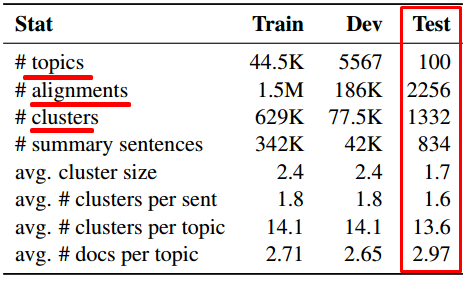

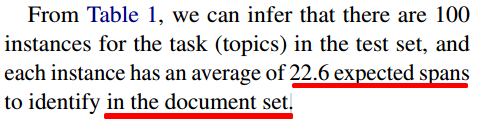

In [15]:
def calculate_num_documents(dict_data):
    return len([doc for test_text in dict_data.values() for doc in test_text["documents"]])

print(f'Number of Multinews (tests/ multi documents): {len(salience)}')
print(f'Number of document: {calculate_num_documents(salience)}')

Number of Multinews (tests/ multi documents): 98
Number of document: 275


In [16]:
num_topics = len([topic for topic in salience.keys()])
train_size, dev_size = int(num_topics * 0.20), int(num_topics * 0.35)
test_size = num_topics - train_size - dev_size

def train_test_split(data_dict, start_index, end_index):
    items = list(data_dict.items())
    split_data = dict(items[start_index: end_index])
    
    return split_data

train_salience = train_test_split(salience, 0, train_size)
dev_salience = train_test_split(salience, train_size, train_size + dev_size)
test_salience = train_test_split(salience, train_size + dev_size, train_size + dev_size + test_size)

In [17]:
print(f'Train size: {len(train_salience)}')
print(f'Dev size: {len(dev_salience)}')
print(f'Test size: {len(test_salience)}')
print(f'Train documents count: {calculate_num_documents(train_salience)}')
print(f'Dev documents count: {calculate_num_documents(dev_salience)}')
print(f'Test documents count: {calculate_num_documents(test_salience)}')

Train size: 19
Dev size: 34
Test size: 45
Train documents count: 60
Dev documents count: 79
Test documents count: 136


Evaluation of Salience detection:

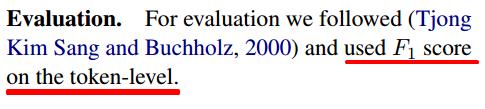

In [18]:
# TODO this is not good need to be refactored
class SalienceSignature(dspy.Signature):
    """Below are documents on the same topic in different user messages. Please copy exactly salient sub-sentenial spans. Do not change the copied text."""

    documents = dspy.InputField(desc='news data')
    salience  = dspy.OutputField()

# TODO this is not good need to be refactored
class PropositionClusteringSignature(dspy.Signature):
    """Below are text spans with indexes. Please cluster them into groups. Each group should contain spans that share the same information. Return a dict in the following format <SPAN IDX>:<CLUSTER IDX>. Do not add anything beside the dict."""

    text_spans = dspy.InputField()
    clusters = dspy.OutputField()

In [30]:
class SaliencePredict(dspy.Module):
    def __init__(self):
        super().__init__()

        self.generate_salience = dspy.Predict(SalienceSignature)
    
    def forward(self, documents):
        return self.generate_salience(documents=documents)

In [ ]:
generate_salience = SaliencePredict()



In [ ]:
config_salience = {
    'metric': 
}

In [3]:
llm = dspy.OllamaLocal(model='llama3:8b-instruct-q8_0')

In [4]:
llm('Who are you')

["I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text based on the input I receive.\n\nI was trained on a massive dataset of text from various sources, including books, articles, and websites. This training enables me to understand natural language processing (NLP) and generate human-like responses.\n\nMy capabilities include:\n\n1. Answering questions: I can provide information on a wide range of topics, from science and history to entertainment and culture.\n2. Generating text: I can create text based on a prompt or topic, including stories, articles, and even entire"]

In [9]:
llm.inspect_history()




Who are you I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text based on the input I receive.

I was trained on a massive dataset of text from various sources, including books, articles, and websites. This training enables me to understand natural language processing (NLP) and generate human-like responses.

My capabilities include:

1. Answering questions: I can provide information on a wide range of topics, from science and history to entertainment and culture.
2. Generating text: I can create text based on a prompt or topic, including stories, articles, and even entire





"\n\n\nWho are you\x1b I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation, answer questions, and even generate text based on the input I receive.\n\nI was trained on a massive dataset of text from various sources, including books, articles, and websites. This training enables me to understand natural language processing (NLP) and generate human-like responses.\n\nMy capabilities include:\n\n1. Answering questions: I can provide information on a wide range of topics, from science and history to entertainment and culture.\n2. Generating text: I can create text based on a prompt or topic, including stories, articles, and even entire\x1b\n\n\n"

LLama3 have context size of 8K

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [29]:
len(tokenizer.encode(train_salience['test49']['documents'][0]))

9756